In [1]:
import numpy as np
import pandas as pd
import histogrammar as hg
import matplotlib.pyplot as plt

In [2]:
import matplotlib

In [3]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from scipy.stats import chi2, norm


In [4]:
from mmur.stats.kde_utils import kde_process_data, kde_make_transformers, kde_bw

In [5]:
%matplotlib inline

In [6]:
plt.style.use('ggplot')
plt.rc('font', size=12)


In [7]:
# generate fake y and y_prob

In [8]:
np.random.seed(43)

In [9]:
X0 = np.random.exponential(0.4, 2000)
X0 = X0[X0 < 1]
y0 = np.zeros(len(X0))

X1 = np.random.exponential(0.25, 1000)
X1 = 1. - X1[X1 < 1]
y1 = np.ones(len(X1))

In [10]:
X = np.concatenate([X0, X1])
y = np.concatenate([y0, y1])

<AxesSubplot:title={'center':'SparselyBin'}>

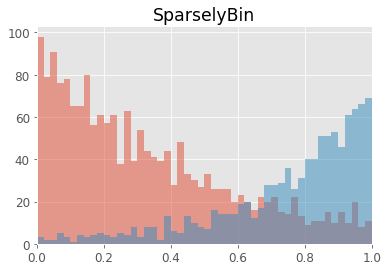

In [11]:
h0 = hg.SparselyBin(binWidth=0.02)
h0.fill.numpy(X0)
h1 = hg.SparselyBin(binWidth=0.02)
h1.fill.numpy(X1)

h0.plot.matplotlib(alpha=0.5)
h1.plot.matplotlib(alpha=0.5)

In [12]:
precision, recall, thresholds = precision_recall_curve(y, X)

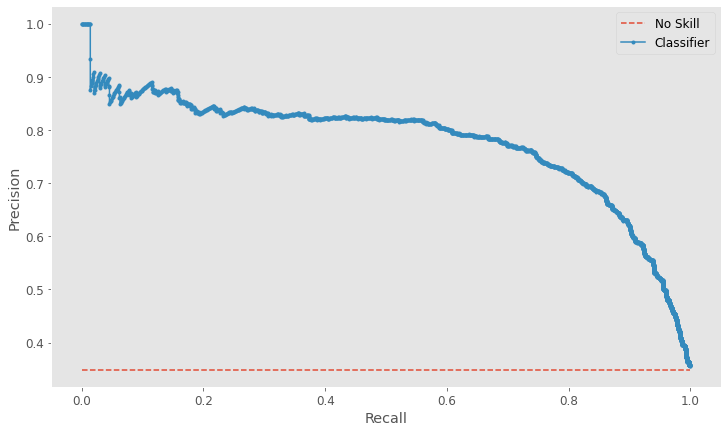

In [13]:
# plot the precision-recall curves (sklearn)
plt.figure(figsize=(12,7))
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Classifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.grid()
# show the plot
plt.show()

In [14]:
# real y and y_prob

In [15]:
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)

precision, recall, thresholds = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(recall, precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))


Logistic: f1=0.841 auc=0.898


<Figure size 864x504 with 0 Axes>

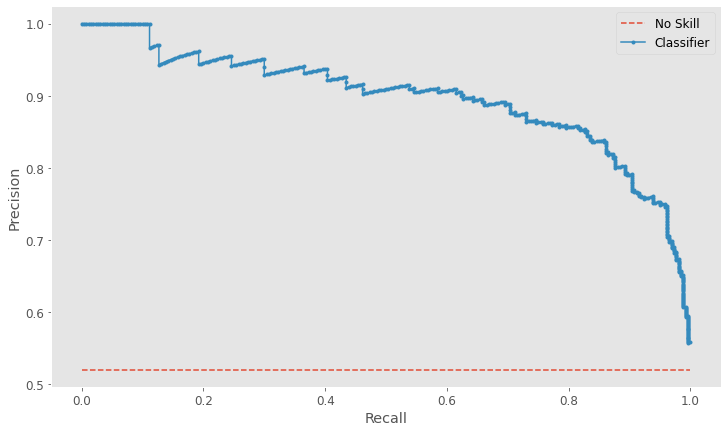

In [16]:
# plot the precision-recall curves
plt.figure(figsize=(12,7))
no_skill = len(testy[testy==1]) / len(testy)
plt.figure(figsize=(12,7))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Classifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.grid()
# show the plot
plt.show()

In [17]:
# pick a set

In [18]:
if False:
    y_true = y
    y_prob = X

In [19]:
y_true = testy # [testy==1]
y_prob = lr_probs # [testy==1]


In [20]:
y_true = y_true.astype(int)

In [21]:
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

In [22]:
# add zero threshold (missing by default?)
thresholds = np.concatenate([[0.], thresholds])

In [23]:
#############################
# Calculate Uncertainty bands

N = len(y_true)

# Getting TP, FN, FP
# remark: computing them with metrics.confusion_matrix() takes too much time
P = np.array([sum(y_true)] * len(thresholds))
# we use ">= thr" like in precision_recall_curve():
TP = np.array([((y_prob >= thr) & y_true).sum() for thr in thresholds])
PP = np.array([(y_prob >= thr).sum() for thr in thresholds])
FN = P - TP
FP = PP - TP
TN = N - TP - FP - FN

In [24]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)

In [25]:
# confidence limits for 1, 2, and 3 standard deviations in 1 dimension
nstd1 = 2. * (norm.cdf(1) - 0.5)
nstd2 = 2. * (norm.cdf(2) - 0.5)
nstd3 = 2. * (norm.cdf(3) - 0.5)
#print (nstd1, nstd2, nstd3)

# confidence limits in two dimensions
l90 = chi2.ppf(0.90, 2)
# 68.3% = 1 std dev (1 dim)
l68 = chi2.ppf(nstd1, 2)
# 95.4% = 2 std dev (1 dim)
l95 = chi2.ppf(nstd2, 2)
# 99.7% = 3 std dev (1 dim)
l99 = chi2.ppf(nstd3, 2)

# scales with which to scale up r1 and r2
scale1 = np.sqrt(l68)
scale2 = np.sqrt(l95)
scale3 = np.sqrt(l99)
#print (scale1, scale2, scale3)

print (l68, l90, l95, l99)

2.295748928898636 4.605170185988092 6.180074306244173 11.829158081900795


In [50]:
from scipy.special import xlogy

def phat(rec, prec, x_tp, x_fp, x_tn, x_fn):
    """Fit probability parameters of confusion matrix under the constraint of 
    fixed recall and precision
    """
    n4 = x_tp + x_fp + x_tn + x_fn
    n3 = x_tp + x_fp + x_fn  # numerator
    alpha = 1/prec + 1/rec - 1  # factor in front of n
    #alpha = (1-prec)/prec + (1-rec)/rec + 1  # factor in front of n
    p_tp = (n3 / n4) * (1. / alpha)
    p_fn = ((1-rec)/rec) * p_tp
    p_fp = ((1-prec)/prec) * p_tp
    p_tn = 1. - p_fn - p_fp - p_tp 
    # prevent negative values to due machine level noise
    if isinstance(p_tn, np.ndarray):
        p_tn[p_tn < 0] = 0
    elif isinstance(p_tn, float) and p_tn < 0:
        p_tn = 0.
    return p_tp, p_fp, p_tn, p_fn

def phat_max(rec, prec, x_tp, x_fp, x_tn, x_fn):
    """Fit probability parameters of confusion matrix under the constraint of 
    fixed recall and precision
    """
    n4 = x_tp + x_fp + x_tn + x_fn
    n3 = x_tp + x_fp + x_fn  # numerator (small mistake in the paper Xtn instead of Xtp)
    alpha = (1-prec)/prec + (1-rec)/rec + 1  # factor in front of n
    p_tp = (n3 / n4) * (1. / alpha)
    p_fn = ((1-rec)/rec) * p_tp
    p_fp = ((1-prec)/prec) * p_tp
    p_tn = 1. - p_fn - p_fp - p_tp 
    # prevent negative values to due machine level noise
    if isinstance(p_tn, np.ndarray):
        p_tn[p_tn < 0] = 0
    elif isinstance(p_tn, float) and p_tn < 0:
        p_tn = 0.
    return p_tp, p_fp, p_tn, p_fn


def nll(rec, prec, x_tp, x_fp, x_tn, x_fn):
    """Return -2logp of multinomial distribution fixed at certain recall and precision

    Two steps:
    1. Fit with fixed recall and precision 
    2. Fit with all probability parameters free
    
    Return the difference in -2 log L
    """
    # optimal fit of x
    n4 = x_tp + x_fp + x_tn + x_fn
    p_fn0 = x_fn / n4
    p_tp0 = x_tp / n4
    p_fp0 = x_fp / n4
    p_tn0 = x_tn / n4
    nll_minimum = -2 * xlogy(x_tp, p_tp0) - 2 * xlogy(x_fp, p_fp0) - 2 * xlogy(x_fn, p_fn0) - 2 * xlogy(x_tn, p_tn0)    

    # fit of x constrained to recall and precision 
    p_tp, p_fp, p_tn, p_fn = phat(rec, prec, x_tp, x_fp, x_tn, x_fn)    
    nll_value = -2 * xlogy(x_tp, p_tp) - 2 * xlogy(x_fp, p_fp) - 2 * xlogy(x_fn, p_fn) - 2 * xlogy(x_tn, p_tn)

    # return the difference
    return nll_value - nll_minimum

def get_PRgrid(x_tp, x_fp, x_fn, nbins = 100, epsilon = 1e-4):
    """Make a rough estimate for the range of the precision-recall grid to scan
    """

    # epsilon to prevent division by zero at edge
    # Note: true values recall=100% or prec=100% can only hit boundary if fn=0 or fp=0
    # else clip max values of recall and precision
    max_rec_clip = 0 if x_fn == 0 else epsilon
    max_prec_clip = 0 if x_fp == 0 else epsilon
    
    rec = x_tp / (x_tp + x_fn)
    prec = x_tp / (x_tp + x_fp)  

    # get rough estimates of sigma_rec and sigma_precision
    # for rec=0,1 the uncertainty formula gives zero, correct for this 
    if rec == 0:
        rec_for_sigma = 1 / (x_tp + x_fn)
    elif rec == 1:
        rec_for_sigma = (x_tp + x_fn - 1) / (x_tp + x_fn)
    else:
        rec_for_sigma = rec
    # for prec=0,1 the uncertainty formula gives zero, correct for this 
    if prec == 0:
        prec_for_sigma = 1 / (x_tp + x_fp)
    elif prec == 1:
        prec_for_sigma = (x_tp + x_fp - 1) / (x_tp + x_fp)
    else:
        prec_for_sigma = prec
    # rough estimates of sigma_rec and sigma_precision    
    sigma_rec = np.sqrt((rec_for_sigma*(1-rec_for_sigma))/(x_tp + x_fn))
    sigma_prec = np.sqrt((prec_for_sigma*(1-prec_for_sigma))/(x_tp + x_fp))

    # ranges of P and R to scan
    rec_max = min(rec + 6 * sigma_rec, 1 - max_rec_clip)
    rec_min = max(rec - 7 * sigma_rec, epsilon)
    prec_max = min(prec + 6 * sigma_prec, 1 - max_prec_clip)
    prec_min = max(prec - 7 * sigma_prec, epsilon)

    # make PR grid to scan
    rx = np.linspace(rec_min, rec_max, nbins)
    py = np.linspace(prec_min, prec_max, nbins)
    RX, PY = np.meshgrid(rx, py)
    
    return RX, PY


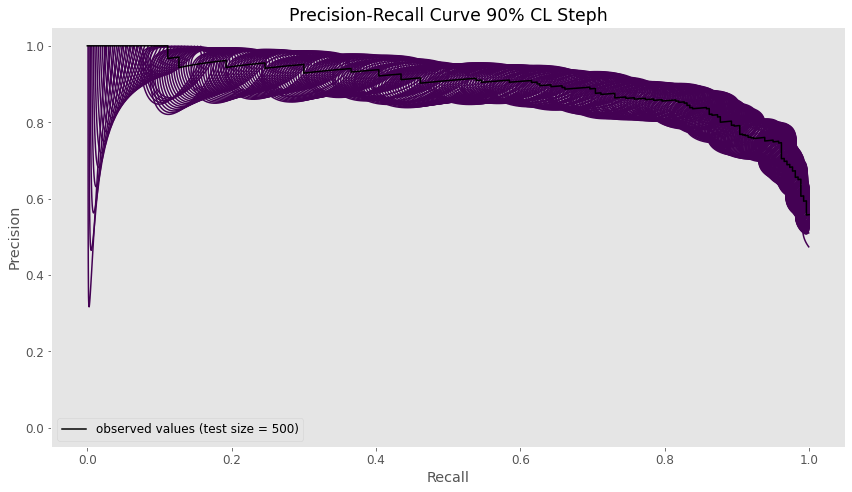

In [52]:
fig, ax = plt.subplots(figsize=(12, 7))

# For each point in the precision-recall curve plot an ellipse
for i, (r, p, x_tp, x_fp, x_tn, x_fn) in enumerate(zip(recall, precision, TP, FP, TN, FN)):
    RX, PY = get_PRgrid(x_tp, x_fp, x_fn)
    chi2 = nll(RX, PY, x_tp, x_fp, x_tn, x_fn)
    CS = ax.contour(RX, PY, chi2, levels=[l90])
    
# Plot precision-recall curve
cmap = plt.get_cmap("tab10")
ax.plot(recall, precision, label='observed values (test size = 500)', color='black')

ax.set_xlim((-0.05, 1.05))
ax.set_ylim((-0.05, 1.05))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#ax.set_title(f'Precision-Recall Curve ±1σ')
ax.set_title(f'Precision-Recall Curve 90% CL Steph')
ax.legend(loc="lower left")
ax.grid()

plt.tight_layout()
plt.savefig('PR_uncertainties.pdf')


### NOTE requires current HEAD of unstable branch of mmu

install with:
```
pip install git+https://github.com/RUrlus/ModelMetricUncertainty@unstable
```

In [28]:
import mmu
from mmu.lib._mmu_core import multinomial_uncertainty_over_grid_thresholds

In [29]:
import scipy.stats as sts
import seaborn as sns

In [30]:
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

In [31]:
prec_grid = rec_grid = np.linspace(1e-6, 1 - 1e-6, 1000)

In [33]:
conf_mats = mmu.confusion_matrices_thresholds(y=y_true, scores=y_prob, thresholds=thresholds)

### Quick and dirty implementation

`multinomial_uncertainty_over_grid` only store the chi2 statistic in scores when it is smaller than the current value for that grid point.
The function also only computes and potentially sets values in a grid with boundaries as determined by `n_sigmas` times the marginal std dev of the prec and rec.

In [34]:
scores = np.ones((prec_grid.size, rec_grid.size)) * 1e4
multinomial_uncertainty_over_grid_thresholds(
    n_conf_mats=conf_mats.shape[0],
    precs_grid=prec_grid,
    recs_grid=rec_grid,
    conf_mat=conf_mats,
    scores=scores
)

TypeError: multinomial_uncertainty_over_grid_thresholds(): incompatible function arguments. The following argument types are supported:
    1. (n_conf_mats: int, precs_grid: numpy.ndarray[numpy.float64], recs_grid: numpy.ndarray[numpy.float64], conf_mat: numpy.ndarray[numpy.int64], n_sigmas: float = 6.0, epsilon: float = 0.0001) -> numpy.ndarray[numpy.float64]

Invoked with: kwargs: n_conf_mats=466, precs_grid=array([1.00000000e-06, 1.00199900e-03, 2.00299800e-03, 3.00399700e-03,
       4.00499600e-03, 5.00599499e-03, 6.00699399e-03, 7.00799299e-03,
       8.00899199e-03, 9.00999099e-03, 1.00109900e-02, 1.10119890e-02,
       1.20129880e-02, 1.30139870e-02, 1.40149860e-02, 1.50159850e-02,
       1.60169840e-02, 1.70179830e-02, 1.80189820e-02, 1.90199810e-02,
       2.00209800e-02, 2.10219790e-02, 2.20229780e-02, 2.30239770e-02,
       2.40249760e-02, 2.50259750e-02, 2.60269740e-02, 2.70279730e-02,
       2.80289720e-02, 2.90299710e-02, 3.00309700e-02, 3.10319690e-02,
       3.20329680e-02, 3.30339670e-02, 3.40349660e-02, 3.50359650e-02,
       3.60369640e-02, 3.70379630e-02, 3.80389620e-02, 3.90399610e-02,
       4.00409600e-02, 4.10419590e-02, 4.20429580e-02, 4.30439570e-02,
       4.40449560e-02, 4.50459550e-02, 4.60469540e-02, 4.70479530e-02,
       4.80489520e-02, 4.90499510e-02, 5.00509499e-02, 5.10519489e-02,
       5.20529479e-02, 5.30539469e-02, 5.40549459e-02, 5.50559449e-02,
       5.60569439e-02, 5.70579429e-02, 5.80589419e-02, 5.90599409e-02,
       6.00609399e-02, 6.10619389e-02, 6.20629379e-02, 6.30639369e-02,
       6.40649359e-02, 6.50659349e-02, 6.60669339e-02, 6.70679329e-02,
       6.80689319e-02, 6.90699309e-02, 7.00709299e-02, 7.10719289e-02,
       7.20729279e-02, 7.30739269e-02, 7.40749259e-02, 7.50759249e-02,
       7.60769239e-02, 7.70779229e-02, 7.80789219e-02, 7.90799209e-02,
       8.00809199e-02, 8.10819189e-02, 8.20829179e-02, 8.30839169e-02,
       8.40849159e-02, 8.50859149e-02, 8.60869139e-02, 8.70879129e-02,
       8.80889119e-02, 8.90899109e-02, 9.00909099e-02, 9.10919089e-02,
       9.20929079e-02, 9.30939069e-02, 9.40949059e-02, 9.50959049e-02,
       9.60969039e-02, 9.70979029e-02, 9.80989019e-02, 9.90999009e-02,
       1.00100900e-01, 1.01101899e-01, 1.02102898e-01, 1.03103897e-01,
       1.04104896e-01, 1.05105895e-01, 1.06106894e-01, 1.07107893e-01,
       1.08108892e-01, 1.09109891e-01, 1.10110890e-01, 1.11111889e-01,
       1.12112888e-01, 1.13113887e-01, 1.14114886e-01, 1.15115885e-01,
       1.16116884e-01, 1.17117883e-01, 1.18118882e-01, 1.19119881e-01,
       1.20120880e-01, 1.21121879e-01, 1.22122878e-01, 1.23123877e-01,
       1.24124876e-01, 1.25125875e-01, 1.26126874e-01, 1.27127873e-01,
       1.28128872e-01, 1.29129871e-01, 1.30130870e-01, 1.31131869e-01,
       1.32132868e-01, 1.33133867e-01, 1.34134866e-01, 1.35135865e-01,
       1.36136864e-01, 1.37137863e-01, 1.38138862e-01, 1.39139861e-01,
       1.40140860e-01, 1.41141859e-01, 1.42142858e-01, 1.43143857e-01,
       1.44144856e-01, 1.45145855e-01, 1.46146854e-01, 1.47147853e-01,
       1.48148852e-01, 1.49149851e-01, 1.50150850e-01, 1.51151849e-01,
       1.52152848e-01, 1.53153847e-01, 1.54154846e-01, 1.55155845e-01,
       1.56156844e-01, 1.57157843e-01, 1.58158842e-01, 1.59159841e-01,
       1.60160840e-01, 1.61161839e-01, 1.62162838e-01, 1.63163837e-01,
       1.64164836e-01, 1.65165835e-01, 1.66166834e-01, 1.67167833e-01,
       1.68168832e-01, 1.69169831e-01, 1.70170830e-01, 1.71171829e-01,
       1.72172828e-01, 1.73173827e-01, 1.74174826e-01, 1.75175825e-01,
       1.76176824e-01, 1.77177823e-01, 1.78178822e-01, 1.79179821e-01,
       1.80180820e-01, 1.81181819e-01, 1.82182818e-01, 1.83183817e-01,
       1.84184816e-01, 1.85185815e-01, 1.86186814e-01, 1.87187813e-01,
       1.88188812e-01, 1.89189811e-01, 1.90190810e-01, 1.91191809e-01,
       1.92192808e-01, 1.93193807e-01, 1.94194806e-01, 1.95195805e-01,
       1.96196804e-01, 1.97197803e-01, 1.98198802e-01, 1.99199801e-01,
       2.00200800e-01, 2.01201799e-01, 2.02202798e-01, 2.03203797e-01,
       2.04204796e-01, 2.05205795e-01, 2.06206794e-01, 2.07207793e-01,
       2.08208792e-01, 2.09209791e-01, 2.10210790e-01, 2.11211789e-01,
       2.12212788e-01, 2.13213787e-01, 2.14214786e-01, 2.15215785e-01,
       2.16216784e-01, 2.17217783e-01, 2.18218782e-01, 2.19219781e-01,
       2.20220780e-01, 2.21221779e-01, 2.22222778e-01, 2.23223777e-01,
       2.24224776e-01, 2.25225775e-01, 2.26226774e-01, 2.27227773e-01,
       2.28228772e-01, 2.29229771e-01, 2.30230770e-01, 2.31231769e-01,
       2.32232768e-01, 2.33233767e-01, 2.34234766e-01, 2.35235765e-01,
       2.36236764e-01, 2.37237763e-01, 2.38238762e-01, 2.39239761e-01,
       2.40240760e-01, 2.41241759e-01, 2.42242758e-01, 2.43243757e-01,
       2.44244756e-01, 2.45245755e-01, 2.46246754e-01, 2.47247753e-01,
       2.48248752e-01, 2.49249751e-01, 2.50250750e-01, 2.51251749e-01,
       2.52252748e-01, 2.53253747e-01, 2.54254746e-01, 2.55255745e-01,
       2.56256744e-01, 2.57257743e-01, 2.58258742e-01, 2.59259741e-01,
       2.60260740e-01, 2.61261739e-01, 2.62262738e-01, 2.63263737e-01,
       2.64264736e-01, 2.65265735e-01, 2.66266734e-01, 2.67267733e-01,
       2.68268732e-01, 2.69269731e-01, 2.70270730e-01, 2.71271729e-01,
       2.72272728e-01, 2.73273727e-01, 2.74274726e-01, 2.75275725e-01,
       2.76276724e-01, 2.77277723e-01, 2.78278722e-01, 2.79279721e-01,
       2.80280720e-01, 2.81281719e-01, 2.82282718e-01, 2.83283717e-01,
       2.84284716e-01, 2.85285715e-01, 2.86286714e-01, 2.87287713e-01,
       2.88288712e-01, 2.89289711e-01, 2.90290710e-01, 2.91291709e-01,
       2.92292708e-01, 2.93293707e-01, 2.94294706e-01, 2.95295705e-01,
       2.96296704e-01, 2.97297703e-01, 2.98298702e-01, 2.99299701e-01,
       3.00300700e-01, 3.01301699e-01, 3.02302698e-01, 3.03303697e-01,
       3.04304696e-01, 3.05305695e-01, 3.06306694e-01, 3.07307693e-01,
       3.08308692e-01, 3.09309691e-01, 3.10310690e-01, 3.11311689e-01,
       3.12312688e-01, 3.13313687e-01, 3.14314686e-01, 3.15315685e-01,
       3.16316684e-01, 3.17317683e-01, 3.18318682e-01, 3.19319681e-01,
       3.20320680e-01, 3.21321679e-01, 3.22322678e-01, 3.23323677e-01,
       3.24324676e-01, 3.25325675e-01, 3.26326674e-01, 3.27327673e-01,
       3.28328672e-01, 3.29329671e-01, 3.30330670e-01, 3.31331669e-01,
       3.32332668e-01, 3.33333667e-01, 3.34334666e-01, 3.35335665e-01,
       3.36336664e-01, 3.37337663e-01, 3.38338662e-01, 3.39339661e-01,
       3.40340660e-01, 3.41341659e-01, 3.42342658e-01, 3.43343657e-01,
       3.44344656e-01, 3.45345655e-01, 3.46346654e-01, 3.47347653e-01,
       3.48348652e-01, 3.49349651e-01, 3.50350650e-01, 3.51351649e-01,
       3.52352648e-01, 3.53353647e-01, 3.54354646e-01, 3.55355645e-01,
       3.56356644e-01, 3.57357643e-01, 3.58358642e-01, 3.59359641e-01,
       3.60360640e-01, 3.61361639e-01, 3.62362638e-01, 3.63363637e-01,
       3.64364636e-01, 3.65365635e-01, 3.66366634e-01, 3.67367633e-01,
       3.68368632e-01, 3.69369631e-01, 3.70370630e-01, 3.71371629e-01,
       3.72372628e-01, 3.73373627e-01, 3.74374626e-01, 3.75375625e-01,
       3.76376624e-01, 3.77377623e-01, 3.78378622e-01, 3.79379621e-01,
       3.80380620e-01, 3.81381619e-01, 3.82382618e-01, 3.83383617e-01,
       3.84384616e-01, 3.85385615e-01, 3.86386614e-01, 3.87387613e-01,
       3.88388612e-01, 3.89389611e-01, 3.90390610e-01, 3.91391609e-01,
       3.92392608e-01, 3.93393607e-01, 3.94394606e-01, 3.95395605e-01,
       3.96396604e-01, 3.97397603e-01, 3.98398602e-01, 3.99399601e-01,
       4.00400600e-01, 4.01401599e-01, 4.02402598e-01, 4.03403597e-01,
       4.04404596e-01, 4.05405595e-01, 4.06406594e-01, 4.07407593e-01,
       4.08408592e-01, 4.09409591e-01, 4.10410590e-01, 4.11411589e-01,
       4.12412588e-01, 4.13413587e-01, 4.14414586e-01, 4.15415585e-01,
       4.16416584e-01, 4.17417583e-01, 4.18418582e-01, 4.19419581e-01,
       4.20420580e-01, 4.21421579e-01, 4.22422578e-01, 4.23423577e-01,
       4.24424576e-01, 4.25425575e-01, 4.26426574e-01, 4.27427573e-01,
       4.28428572e-01, 4.29429571e-01, 4.30430570e-01, 4.31431569e-01,
       4.32432568e-01, 4.33433567e-01, 4.34434566e-01, 4.35435565e-01,
       4.36436564e-01, 4.37437563e-01, 4.38438562e-01, 4.39439561e-01,
       4.40440560e-01, 4.41441559e-01, 4.42442558e-01, 4.43443557e-01,
       4.44444556e-01, 4.45445555e-01, 4.46446554e-01, 4.47447553e-01,
       4.48448552e-01, 4.49449551e-01, 4.50450550e-01, 4.51451549e-01,
       4.52452548e-01, 4.53453547e-01, 4.54454546e-01, 4.55455545e-01,
       4.56456544e-01, 4.57457543e-01, 4.58458542e-01, 4.59459541e-01,
       4.60460540e-01, 4.61461539e-01, 4.62462538e-01, 4.63463537e-01,
       4.64464536e-01, 4.65465535e-01, 4.66466534e-01, 4.67467533e-01,
       4.68468532e-01, 4.69469531e-01, 4.70470530e-01, 4.71471529e-01,
       4.72472528e-01, 4.73473527e-01, 4.74474526e-01, 4.75475525e-01,
       4.76476524e-01, 4.77477523e-01, 4.78478522e-01, 4.79479521e-01,
       4.80480520e-01, 4.81481519e-01, 4.82482518e-01, 4.83483517e-01,
       4.84484516e-01, 4.85485515e-01, 4.86486514e-01, 4.87487513e-01,
       4.88488512e-01, 4.89489511e-01, 4.90490510e-01, 4.91491509e-01,
       4.92492508e-01, 4.93493507e-01, 4.94494506e-01, 4.95495505e-01,
       4.96496504e-01, 4.97497503e-01, 4.98498502e-01, 4.99499501e-01,
       5.00500499e-01, 5.01501498e-01, 5.02502497e-01, 5.03503496e-01,
       5.04504495e-01, 5.05505494e-01, 5.06506493e-01, 5.07507492e-01,
       5.08508491e-01, 5.09509490e-01, 5.10510489e-01, 5.11511488e-01,
       5.12512487e-01, 5.13513486e-01, 5.14514485e-01, 5.15515484e-01,
       5.16516483e-01, 5.17517482e-01, 5.18518481e-01, 5.19519480e-01,
       5.20520479e-01, 5.21521478e-01, 5.22522477e-01, 5.23523476e-01,
       5.24524475e-01, 5.25525474e-01, 5.26526473e-01, 5.27527472e-01,
       5.28528471e-01, 5.29529470e-01, 5.30530469e-01, 5.31531468e-01,
       5.32532467e-01, 5.33533466e-01, 5.34534465e-01, 5.35535464e-01,
       5.36536463e-01, 5.37537462e-01, 5.38538461e-01, 5.39539460e-01,
       5.40540459e-01, 5.41541458e-01, 5.42542457e-01, 5.43543456e-01,
       5.44544455e-01, 5.45545454e-01, 5.46546453e-01, 5.47547452e-01,
       5.48548451e-01, 5.49549450e-01, 5.50550449e-01, 5.51551448e-01,
       5.52552447e-01, 5.53553446e-01, 5.54554445e-01, 5.55555444e-01,
       5.56556443e-01, 5.57557442e-01, 5.58558441e-01, 5.59559440e-01,
       5.60560439e-01, 5.61561438e-01, 5.62562437e-01, 5.63563436e-01,
       5.64564435e-01, 5.65565434e-01, 5.66566433e-01, 5.67567432e-01,
       5.68568431e-01, 5.69569430e-01, 5.70570429e-01, 5.71571428e-01,
       5.72572427e-01, 5.73573426e-01, 5.74574425e-01, 5.75575424e-01,
       5.76576423e-01, 5.77577422e-01, 5.78578421e-01, 5.79579420e-01,
       5.80580419e-01, 5.81581418e-01, 5.82582417e-01, 5.83583416e-01,
       5.84584415e-01, 5.85585414e-01, 5.86586413e-01, 5.87587412e-01,
       5.88588411e-01, 5.89589410e-01, 5.90590409e-01, 5.91591408e-01,
       5.92592407e-01, 5.93593406e-01, 5.94594405e-01, 5.95595404e-01,
       5.96596403e-01, 5.97597402e-01, 5.98598401e-01, 5.99599400e-01,
       6.00600399e-01, 6.01601398e-01, 6.02602397e-01, 6.03603396e-01,
       6.04604395e-01, 6.05605394e-01, 6.06606393e-01, 6.07607392e-01,
       6.08608391e-01, 6.09609390e-01, 6.10610389e-01, 6.11611388e-01,
       6.12612387e-01, 6.13613386e-01, 6.14614385e-01, 6.15615384e-01,
       6.16616383e-01, 6.17617382e-01, 6.18618381e-01, 6.19619380e-01,
       6.20620379e-01, 6.21621378e-01, 6.22622377e-01, 6.23623376e-01,
       6.24624375e-01, 6.25625374e-01, 6.26626373e-01, 6.27627372e-01,
       6.28628371e-01, 6.29629370e-01, 6.30630369e-01, 6.31631368e-01,
       6.32632367e-01, 6.33633366e-01, 6.34634365e-01, 6.35635364e-01,
       6.36636363e-01, 6.37637362e-01, 6.38638361e-01, 6.39639360e-01,
       6.40640359e-01, 6.41641358e-01, 6.42642357e-01, 6.43643356e-01,
       6.44644355e-01, 6.45645354e-01, 6.46646353e-01, 6.47647352e-01,
       6.48648351e-01, 6.49649350e-01, 6.50650349e-01, 6.51651348e-01,
       6.52652347e-01, 6.53653346e-01, 6.54654345e-01, 6.55655344e-01,
       6.56656343e-01, 6.57657342e-01, 6.58658341e-01, 6.59659340e-01,
       6.60660339e-01, 6.61661338e-01, 6.62662337e-01, 6.63663336e-01,
       6.64664335e-01, 6.65665334e-01, 6.66666333e-01, 6.67667332e-01,
       6.68668331e-01, 6.69669330e-01, 6.70670329e-01, 6.71671328e-01,
       6.72672327e-01, 6.73673326e-01, 6.74674325e-01, 6.75675324e-01,
       6.76676323e-01, 6.77677322e-01, 6.78678321e-01, 6.79679320e-01,
       6.80680319e-01, 6.81681318e-01, 6.82682317e-01, 6.83683316e-01,
       6.84684315e-01, 6.85685314e-01, 6.86686313e-01, 6.87687312e-01,
       6.88688311e-01, 6.89689310e-01, 6.90690309e-01, 6.91691308e-01,
       6.92692307e-01, 6.93693306e-01, 6.94694305e-01, 6.95695304e-01,
       6.96696303e-01, 6.97697302e-01, 6.98698301e-01, 6.99699300e-01,
       7.00700299e-01, 7.01701298e-01, 7.02702297e-01, 7.03703296e-01,
       7.04704295e-01, 7.05705294e-01, 7.06706293e-01, 7.07707292e-01,
       7.08708291e-01, 7.09709290e-01, 7.10710289e-01, 7.11711288e-01,
       7.12712287e-01, 7.13713286e-01, 7.14714285e-01, 7.15715284e-01,
       7.16716283e-01, 7.17717282e-01, 7.18718281e-01, 7.19719280e-01,
       7.20720279e-01, 7.21721278e-01, 7.22722277e-01, 7.23723276e-01,
       7.24724275e-01, 7.25725274e-01, 7.26726273e-01, 7.27727272e-01,
       7.28728271e-01, 7.29729270e-01, 7.30730269e-01, 7.31731268e-01,
       7.32732267e-01, 7.33733266e-01, 7.34734265e-01, 7.35735264e-01,
       7.36736263e-01, 7.37737262e-01, 7.38738261e-01, 7.39739260e-01,
       7.40740259e-01, 7.41741258e-01, 7.42742257e-01, 7.43743256e-01,
       7.44744255e-01, 7.45745254e-01, 7.46746253e-01, 7.47747252e-01,
       7.48748251e-01, 7.49749250e-01, 7.50750249e-01, 7.51751248e-01,
       7.52752247e-01, 7.53753246e-01, 7.54754245e-01, 7.55755244e-01,
       7.56756243e-01, 7.57757242e-01, 7.58758241e-01, 7.59759240e-01,
       7.60760239e-01, 7.61761238e-01, 7.62762237e-01, 7.63763236e-01,
       7.64764235e-01, 7.65765234e-01, 7.66766233e-01, 7.67767232e-01,
       7.68768231e-01, 7.69769230e-01, 7.70770229e-01, 7.71771228e-01,
       7.72772227e-01, 7.73773226e-01, 7.74774225e-01, 7.75775224e-01,
       7.76776223e-01, 7.77777222e-01, 7.78778221e-01, 7.79779220e-01,
       7.80780219e-01, 7.81781218e-01, 7.82782217e-01, 7.83783216e-01,
       7.84784215e-01, 7.85785214e-01, 7.86786213e-01, 7.87787212e-01,
       7.88788211e-01, 7.89789210e-01, 7.90790209e-01, 7.91791208e-01,
       7.92792207e-01, 7.93793206e-01, 7.94794205e-01, 7.95795204e-01,
       7.96796203e-01, 7.97797202e-01, 7.98798201e-01, 7.99799200e-01,
       8.00800199e-01, 8.01801198e-01, 8.02802197e-01, 8.03803196e-01,
       8.04804195e-01, 8.05805194e-01, 8.06806193e-01, 8.07807192e-01,
       8.08808191e-01, 8.09809190e-01, 8.10810189e-01, 8.11811188e-01,
       8.12812187e-01, 8.13813186e-01, 8.14814185e-01, 8.15815184e-01,
       8.16816183e-01, 8.17817182e-01, 8.18818181e-01, 8.19819180e-01,
       8.20820179e-01, 8.21821178e-01, 8.22822177e-01, 8.23823176e-01,
       8.24824175e-01, 8.25825174e-01, 8.26826173e-01, 8.27827172e-01,
       8.28828171e-01, 8.29829170e-01, 8.30830169e-01, 8.31831168e-01,
       8.32832167e-01, 8.33833166e-01, 8.34834165e-01, 8.35835164e-01,
       8.36836163e-01, 8.37837162e-01, 8.38838161e-01, 8.39839160e-01,
       8.40840159e-01, 8.41841158e-01, 8.42842157e-01, 8.43843156e-01,
       8.44844155e-01, 8.45845154e-01, 8.46846153e-01, 8.47847152e-01,
       8.48848151e-01, 8.49849150e-01, 8.50850149e-01, 8.51851148e-01,
       8.52852147e-01, 8.53853146e-01, 8.54854145e-01, 8.55855144e-01,
       8.56856143e-01, 8.57857142e-01, 8.58858141e-01, 8.59859140e-01,
       8.60860139e-01, 8.61861138e-01, 8.62862137e-01, 8.63863136e-01,
       8.64864135e-01, 8.65865134e-01, 8.66866133e-01, 8.67867132e-01,
       8.68868131e-01, 8.69869130e-01, 8.70870129e-01, 8.71871128e-01,
       8.72872127e-01, 8.73873126e-01, 8.74874125e-01, 8.75875124e-01,
       8.76876123e-01, 8.77877122e-01, 8.78878121e-01, 8.79879120e-01,
       8.80880119e-01, 8.81881118e-01, 8.82882117e-01, 8.83883116e-01,
       8.84884115e-01, 8.85885114e-01, 8.86886113e-01, 8.87887112e-01,
       8.88888111e-01, 8.89889110e-01, 8.90890109e-01, 8.91891108e-01,
       8.92892107e-01, 8.93893106e-01, 8.94894105e-01, 8.95895104e-01,
       8.96896103e-01, 8.97897102e-01, 8.98898101e-01, 8.99899100e-01,
       9.00900099e-01, 9.01901098e-01, 9.02902097e-01, 9.03903096e-01,
       9.04904095e-01, 9.05905094e-01, 9.06906093e-01, 9.07907092e-01,
       9.08908091e-01, 9.09909090e-01, 9.10910089e-01, 9.11911088e-01,
       9.12912087e-01, 9.13913086e-01, 9.14914085e-01, 9.15915084e-01,
       9.16916083e-01, 9.17917082e-01, 9.18918081e-01, 9.19919080e-01,
       9.20920079e-01, 9.21921078e-01, 9.22922077e-01, 9.23923076e-01,
       9.24924075e-01, 9.25925074e-01, 9.26926073e-01, 9.27927072e-01,
       9.28928071e-01, 9.29929070e-01, 9.30930069e-01, 9.31931068e-01,
       9.32932067e-01, 9.33933066e-01, 9.34934065e-01, 9.35935064e-01,
       9.36936063e-01, 9.37937062e-01, 9.38938061e-01, 9.39939060e-01,
       9.40940059e-01, 9.41941058e-01, 9.42942057e-01, 9.43943056e-01,
       9.44944055e-01, 9.45945054e-01, 9.46946053e-01, 9.47947052e-01,
       9.48948051e-01, 9.49949050e-01, 9.50950049e-01, 9.51951048e-01,
       9.52952047e-01, 9.53953046e-01, 9.54954045e-01, 9.55955044e-01,
       9.56956043e-01, 9.57957042e-01, 9.58958041e-01, 9.59959040e-01,
       9.60960039e-01, 9.61961038e-01, 9.62962037e-01, 9.63963036e-01,
       9.64964035e-01, 9.65965034e-01, 9.66966033e-01, 9.67967032e-01,
       9.68968031e-01, 9.69969030e-01, 9.70970029e-01, 9.71971028e-01,
       9.72972027e-01, 9.73973026e-01, 9.74974025e-01, 9.75975024e-01,
       9.76976023e-01, 9.77977022e-01, 9.78978021e-01, 9.79979020e-01,
       9.80980019e-01, 9.81981018e-01, 9.82982017e-01, 9.83983016e-01,
       9.84984015e-01, 9.85985014e-01, 9.86986013e-01, 9.87987012e-01,
       9.88988011e-01, 9.89989010e-01, 9.90990009e-01, 9.91991008e-01,
       9.92992007e-01, 9.93993006e-01, 9.94994005e-01, 9.95995004e-01,
       9.96996003e-01, 9.97997002e-01, 9.98998001e-01, 9.99999000e-01]), recs_grid=array([1.00000000e-06, 1.00199900e-03, 2.00299800e-03, 3.00399700e-03,
       4.00499600e-03, 5.00599499e-03, 6.00699399e-03, 7.00799299e-03,
       8.00899199e-03, 9.00999099e-03, 1.00109900e-02, 1.10119890e-02,
       1.20129880e-02, 1.30139870e-02, 1.40149860e-02, 1.50159850e-02,
       1.60169840e-02, 1.70179830e-02, 1.80189820e-02, 1.90199810e-02,
       2.00209800e-02, 2.10219790e-02, 2.20229780e-02, 2.30239770e-02,
       2.40249760e-02, 2.50259750e-02, 2.60269740e-02, 2.70279730e-02,
       2.80289720e-02, 2.90299710e-02, 3.00309700e-02, 3.10319690e-02,
       3.20329680e-02, 3.30339670e-02, 3.40349660e-02, 3.50359650e-02,
       3.60369640e-02, 3.70379630e-02, 3.80389620e-02, 3.90399610e-02,
       4.00409600e-02, 4.10419590e-02, 4.20429580e-02, 4.30439570e-02,
       4.40449560e-02, 4.50459550e-02, 4.60469540e-02, 4.70479530e-02,
       4.80489520e-02, 4.90499510e-02, 5.00509499e-02, 5.10519489e-02,
       5.20529479e-02, 5.30539469e-02, 5.40549459e-02, 5.50559449e-02,
       5.60569439e-02, 5.70579429e-02, 5.80589419e-02, 5.90599409e-02,
       6.00609399e-02, 6.10619389e-02, 6.20629379e-02, 6.30639369e-02,
       6.40649359e-02, 6.50659349e-02, 6.60669339e-02, 6.70679329e-02,
       6.80689319e-02, 6.90699309e-02, 7.00709299e-02, 7.10719289e-02,
       7.20729279e-02, 7.30739269e-02, 7.40749259e-02, 7.50759249e-02,
       7.60769239e-02, 7.70779229e-02, 7.80789219e-02, 7.90799209e-02,
       8.00809199e-02, 8.10819189e-02, 8.20829179e-02, 8.30839169e-02,
       8.40849159e-02, 8.50859149e-02, 8.60869139e-02, 8.70879129e-02,
       8.80889119e-02, 8.90899109e-02, 9.00909099e-02, 9.10919089e-02,
       9.20929079e-02, 9.30939069e-02, 9.40949059e-02, 9.50959049e-02,
       9.60969039e-02, 9.70979029e-02, 9.80989019e-02, 9.90999009e-02,
       1.00100900e-01, 1.01101899e-01, 1.02102898e-01, 1.03103897e-01,
       1.04104896e-01, 1.05105895e-01, 1.06106894e-01, 1.07107893e-01,
       1.08108892e-01, 1.09109891e-01, 1.10110890e-01, 1.11111889e-01,
       1.12112888e-01, 1.13113887e-01, 1.14114886e-01, 1.15115885e-01,
       1.16116884e-01, 1.17117883e-01, 1.18118882e-01, 1.19119881e-01,
       1.20120880e-01, 1.21121879e-01, 1.22122878e-01, 1.23123877e-01,
       1.24124876e-01, 1.25125875e-01, 1.26126874e-01, 1.27127873e-01,
       1.28128872e-01, 1.29129871e-01, 1.30130870e-01, 1.31131869e-01,
       1.32132868e-01, 1.33133867e-01, 1.34134866e-01, 1.35135865e-01,
       1.36136864e-01, 1.37137863e-01, 1.38138862e-01, 1.39139861e-01,
       1.40140860e-01, 1.41141859e-01, 1.42142858e-01, 1.43143857e-01,
       1.44144856e-01, 1.45145855e-01, 1.46146854e-01, 1.47147853e-01,
       1.48148852e-01, 1.49149851e-01, 1.50150850e-01, 1.51151849e-01,
       1.52152848e-01, 1.53153847e-01, 1.54154846e-01, 1.55155845e-01,
       1.56156844e-01, 1.57157843e-01, 1.58158842e-01, 1.59159841e-01,
       1.60160840e-01, 1.61161839e-01, 1.62162838e-01, 1.63163837e-01,
       1.64164836e-01, 1.65165835e-01, 1.66166834e-01, 1.67167833e-01,
       1.68168832e-01, 1.69169831e-01, 1.70170830e-01, 1.71171829e-01,
       1.72172828e-01, 1.73173827e-01, 1.74174826e-01, 1.75175825e-01,
       1.76176824e-01, 1.77177823e-01, 1.78178822e-01, 1.79179821e-01,
       1.80180820e-01, 1.81181819e-01, 1.82182818e-01, 1.83183817e-01,
       1.84184816e-01, 1.85185815e-01, 1.86186814e-01, 1.87187813e-01,
       1.88188812e-01, 1.89189811e-01, 1.90190810e-01, 1.91191809e-01,
       1.92192808e-01, 1.93193807e-01, 1.94194806e-01, 1.95195805e-01,
       1.96196804e-01, 1.97197803e-01, 1.98198802e-01, 1.99199801e-01,
       2.00200800e-01, 2.01201799e-01, 2.02202798e-01, 2.03203797e-01,
       2.04204796e-01, 2.05205795e-01, 2.06206794e-01, 2.07207793e-01,
       2.08208792e-01, 2.09209791e-01, 2.10210790e-01, 2.11211789e-01,
       2.12212788e-01, 2.13213787e-01, 2.14214786e-01, 2.15215785e-01,
       2.16216784e-01, 2.17217783e-01, 2.18218782e-01, 2.19219781e-01,
       2.20220780e-01, 2.21221779e-01, 2.22222778e-01, 2.23223777e-01,
       2.24224776e-01, 2.25225775e-01, 2.26226774e-01, 2.27227773e-01,
       2.28228772e-01, 2.29229771e-01, 2.30230770e-01, 2.31231769e-01,
       2.32232768e-01, 2.33233767e-01, 2.34234766e-01, 2.35235765e-01,
       2.36236764e-01, 2.37237763e-01, 2.38238762e-01, 2.39239761e-01,
       2.40240760e-01, 2.41241759e-01, 2.42242758e-01, 2.43243757e-01,
       2.44244756e-01, 2.45245755e-01, 2.46246754e-01, 2.47247753e-01,
       2.48248752e-01, 2.49249751e-01, 2.50250750e-01, 2.51251749e-01,
       2.52252748e-01, 2.53253747e-01, 2.54254746e-01, 2.55255745e-01,
       2.56256744e-01, 2.57257743e-01, 2.58258742e-01, 2.59259741e-01,
       2.60260740e-01, 2.61261739e-01, 2.62262738e-01, 2.63263737e-01,
       2.64264736e-01, 2.65265735e-01, 2.66266734e-01, 2.67267733e-01,
       2.68268732e-01, 2.69269731e-01, 2.70270730e-01, 2.71271729e-01,
       2.72272728e-01, 2.73273727e-01, 2.74274726e-01, 2.75275725e-01,
       2.76276724e-01, 2.77277723e-01, 2.78278722e-01, 2.79279721e-01,
       2.80280720e-01, 2.81281719e-01, 2.82282718e-01, 2.83283717e-01,
       2.84284716e-01, 2.85285715e-01, 2.86286714e-01, 2.87287713e-01,
       2.88288712e-01, 2.89289711e-01, 2.90290710e-01, 2.91291709e-01,
       2.92292708e-01, 2.93293707e-01, 2.94294706e-01, 2.95295705e-01,
       2.96296704e-01, 2.97297703e-01, 2.98298702e-01, 2.99299701e-01,
       3.00300700e-01, 3.01301699e-01, 3.02302698e-01, 3.03303697e-01,
       3.04304696e-01, 3.05305695e-01, 3.06306694e-01, 3.07307693e-01,
       3.08308692e-01, 3.09309691e-01, 3.10310690e-01, 3.11311689e-01,
       3.12312688e-01, 3.13313687e-01, 3.14314686e-01, 3.15315685e-01,
       3.16316684e-01, 3.17317683e-01, 3.18318682e-01, 3.19319681e-01,
       3.20320680e-01, 3.21321679e-01, 3.22322678e-01, 3.23323677e-01,
       3.24324676e-01, 3.25325675e-01, 3.26326674e-01, 3.27327673e-01,
       3.28328672e-01, 3.29329671e-01, 3.30330670e-01, 3.31331669e-01,
       3.32332668e-01, 3.33333667e-01, 3.34334666e-01, 3.35335665e-01,
       3.36336664e-01, 3.37337663e-01, 3.38338662e-01, 3.39339661e-01,
       3.40340660e-01, 3.41341659e-01, 3.42342658e-01, 3.43343657e-01,
       3.44344656e-01, 3.45345655e-01, 3.46346654e-01, 3.47347653e-01,
       3.48348652e-01, 3.49349651e-01, 3.50350650e-01, 3.51351649e-01,
       3.52352648e-01, 3.53353647e-01, 3.54354646e-01, 3.55355645e-01,
       3.56356644e-01, 3.57357643e-01, 3.58358642e-01, 3.59359641e-01,
       3.60360640e-01, 3.61361639e-01, 3.62362638e-01, 3.63363637e-01,
       3.64364636e-01, 3.65365635e-01, 3.66366634e-01, 3.67367633e-01,
       3.68368632e-01, 3.69369631e-01, 3.70370630e-01, 3.71371629e-01,
       3.72372628e-01, 3.73373627e-01, 3.74374626e-01, 3.75375625e-01,
       3.76376624e-01, 3.77377623e-01, 3.78378622e-01, 3.79379621e-01,
       3.80380620e-01, 3.81381619e-01, 3.82382618e-01, 3.83383617e-01,
       3.84384616e-01, 3.85385615e-01, 3.86386614e-01, 3.87387613e-01,
       3.88388612e-01, 3.89389611e-01, 3.90390610e-01, 3.91391609e-01,
       3.92392608e-01, 3.93393607e-01, 3.94394606e-01, 3.95395605e-01,
       3.96396604e-01, 3.97397603e-01, 3.98398602e-01, 3.99399601e-01,
       4.00400600e-01, 4.01401599e-01, 4.02402598e-01, 4.03403597e-01,
       4.04404596e-01, 4.05405595e-01, 4.06406594e-01, 4.07407593e-01,
       4.08408592e-01, 4.09409591e-01, 4.10410590e-01, 4.11411589e-01,
       4.12412588e-01, 4.13413587e-01, 4.14414586e-01, 4.15415585e-01,
       4.16416584e-01, 4.17417583e-01, 4.18418582e-01, 4.19419581e-01,
       4.20420580e-01, 4.21421579e-01, 4.22422578e-01, 4.23423577e-01,
       4.24424576e-01, 4.25425575e-01, 4.26426574e-01, 4.27427573e-01,
       4.28428572e-01, 4.29429571e-01, 4.30430570e-01, 4.31431569e-01,
       4.32432568e-01, 4.33433567e-01, 4.34434566e-01, 4.35435565e-01,
       4.36436564e-01, 4.37437563e-01, 4.38438562e-01, 4.39439561e-01,
       4.40440560e-01, 4.41441559e-01, 4.42442558e-01, 4.43443557e-01,
       4.44444556e-01, 4.45445555e-01, 4.46446554e-01, 4.47447553e-01,
       4.48448552e-01, 4.49449551e-01, 4.50450550e-01, 4.51451549e-01,
       4.52452548e-01, 4.53453547e-01, 4.54454546e-01, 4.55455545e-01,
       4.56456544e-01, 4.57457543e-01, 4.58458542e-01, 4.59459541e-01,
       4.60460540e-01, 4.61461539e-01, 4.62462538e-01, 4.63463537e-01,
       4.64464536e-01, 4.65465535e-01, 4.66466534e-01, 4.67467533e-01,
       4.68468532e-01, 4.69469531e-01, 4.70470530e-01, 4.71471529e-01,
       4.72472528e-01, 4.73473527e-01, 4.74474526e-01, 4.75475525e-01,
       4.76476524e-01, 4.77477523e-01, 4.78478522e-01, 4.79479521e-01,
       4.80480520e-01, 4.81481519e-01, 4.82482518e-01, 4.83483517e-01,
       4.84484516e-01, 4.85485515e-01, 4.86486514e-01, 4.87487513e-01,
       4.88488512e-01, 4.89489511e-01, 4.90490510e-01, 4.91491509e-01,
       4.92492508e-01, 4.93493507e-01, 4.94494506e-01, 4.95495505e-01,
       4.96496504e-01, 4.97497503e-01, 4.98498502e-01, 4.99499501e-01,
       5.00500499e-01, 5.01501498e-01, 5.02502497e-01, 5.03503496e-01,
       5.04504495e-01, 5.05505494e-01, 5.06506493e-01, 5.07507492e-01,
       5.08508491e-01, 5.09509490e-01, 5.10510489e-01, 5.11511488e-01,
       5.12512487e-01, 5.13513486e-01, 5.14514485e-01, 5.15515484e-01,
       5.16516483e-01, 5.17517482e-01, 5.18518481e-01, 5.19519480e-01,
       5.20520479e-01, 5.21521478e-01, 5.22522477e-01, 5.23523476e-01,
       5.24524475e-01, 5.25525474e-01, 5.26526473e-01, 5.27527472e-01,
       5.28528471e-01, 5.29529470e-01, 5.30530469e-01, 5.31531468e-01,
       5.32532467e-01, 5.33533466e-01, 5.34534465e-01, 5.35535464e-01,
       5.36536463e-01, 5.37537462e-01, 5.38538461e-01, 5.39539460e-01,
       5.40540459e-01, 5.41541458e-01, 5.42542457e-01, 5.43543456e-01,
       5.44544455e-01, 5.45545454e-01, 5.46546453e-01, 5.47547452e-01,
       5.48548451e-01, 5.49549450e-01, 5.50550449e-01, 5.51551448e-01,
       5.52552447e-01, 5.53553446e-01, 5.54554445e-01, 5.55555444e-01,
       5.56556443e-01, 5.57557442e-01, 5.58558441e-01, 5.59559440e-01,
       5.60560439e-01, 5.61561438e-01, 5.62562437e-01, 5.63563436e-01,
       5.64564435e-01, 5.65565434e-01, 5.66566433e-01, 5.67567432e-01,
       5.68568431e-01, 5.69569430e-01, 5.70570429e-01, 5.71571428e-01,
       5.72572427e-01, 5.73573426e-01, 5.74574425e-01, 5.75575424e-01,
       5.76576423e-01, 5.77577422e-01, 5.78578421e-01, 5.79579420e-01,
       5.80580419e-01, 5.81581418e-01, 5.82582417e-01, 5.83583416e-01,
       5.84584415e-01, 5.85585414e-01, 5.86586413e-01, 5.87587412e-01,
       5.88588411e-01, 5.89589410e-01, 5.90590409e-01, 5.91591408e-01,
       5.92592407e-01, 5.93593406e-01, 5.94594405e-01, 5.95595404e-01,
       5.96596403e-01, 5.97597402e-01, 5.98598401e-01, 5.99599400e-01,
       6.00600399e-01, 6.01601398e-01, 6.02602397e-01, 6.03603396e-01,
       6.04604395e-01, 6.05605394e-01, 6.06606393e-01, 6.07607392e-01,
       6.08608391e-01, 6.09609390e-01, 6.10610389e-01, 6.11611388e-01,
       6.12612387e-01, 6.13613386e-01, 6.14614385e-01, 6.15615384e-01,
       6.16616383e-01, 6.17617382e-01, 6.18618381e-01, 6.19619380e-01,
       6.20620379e-01, 6.21621378e-01, 6.22622377e-01, 6.23623376e-01,
       6.24624375e-01, 6.25625374e-01, 6.26626373e-01, 6.27627372e-01,
       6.28628371e-01, 6.29629370e-01, 6.30630369e-01, 6.31631368e-01,
       6.32632367e-01, 6.33633366e-01, 6.34634365e-01, 6.35635364e-01,
       6.36636363e-01, 6.37637362e-01, 6.38638361e-01, 6.39639360e-01,
       6.40640359e-01, 6.41641358e-01, 6.42642357e-01, 6.43643356e-01,
       6.44644355e-01, 6.45645354e-01, 6.46646353e-01, 6.47647352e-01,
       6.48648351e-01, 6.49649350e-01, 6.50650349e-01, 6.51651348e-01,
       6.52652347e-01, 6.53653346e-01, 6.54654345e-01, 6.55655344e-01,
       6.56656343e-01, 6.57657342e-01, 6.58658341e-01, 6.59659340e-01,
       6.60660339e-01, 6.61661338e-01, 6.62662337e-01, 6.63663336e-01,
       6.64664335e-01, 6.65665334e-01, 6.66666333e-01, 6.67667332e-01,
       6.68668331e-01, 6.69669330e-01, 6.70670329e-01, 6.71671328e-01,
       6.72672327e-01, 6.73673326e-01, 6.74674325e-01, 6.75675324e-01,
       6.76676323e-01, 6.77677322e-01, 6.78678321e-01, 6.79679320e-01,
       6.80680319e-01, 6.81681318e-01, 6.82682317e-01, 6.83683316e-01,
       6.84684315e-01, 6.85685314e-01, 6.86686313e-01, 6.87687312e-01,
       6.88688311e-01, 6.89689310e-01, 6.90690309e-01, 6.91691308e-01,
       6.92692307e-01, 6.93693306e-01, 6.94694305e-01, 6.95695304e-01,
       6.96696303e-01, 6.97697302e-01, 6.98698301e-01, 6.99699300e-01,
       7.00700299e-01, 7.01701298e-01, 7.02702297e-01, 7.03703296e-01,
       7.04704295e-01, 7.05705294e-01, 7.06706293e-01, 7.07707292e-01,
       7.08708291e-01, 7.09709290e-01, 7.10710289e-01, 7.11711288e-01,
       7.12712287e-01, 7.13713286e-01, 7.14714285e-01, 7.15715284e-01,
       7.16716283e-01, 7.17717282e-01, 7.18718281e-01, 7.19719280e-01,
       7.20720279e-01, 7.21721278e-01, 7.22722277e-01, 7.23723276e-01,
       7.24724275e-01, 7.25725274e-01, 7.26726273e-01, 7.27727272e-01,
       7.28728271e-01, 7.29729270e-01, 7.30730269e-01, 7.31731268e-01,
       7.32732267e-01, 7.33733266e-01, 7.34734265e-01, 7.35735264e-01,
       7.36736263e-01, 7.37737262e-01, 7.38738261e-01, 7.39739260e-01,
       7.40740259e-01, 7.41741258e-01, 7.42742257e-01, 7.43743256e-01,
       7.44744255e-01, 7.45745254e-01, 7.46746253e-01, 7.47747252e-01,
       7.48748251e-01, 7.49749250e-01, 7.50750249e-01, 7.51751248e-01,
       7.52752247e-01, 7.53753246e-01, 7.54754245e-01, 7.55755244e-01,
       7.56756243e-01, 7.57757242e-01, 7.58758241e-01, 7.59759240e-01,
       7.60760239e-01, 7.61761238e-01, 7.62762237e-01, 7.63763236e-01,
       7.64764235e-01, 7.65765234e-01, 7.66766233e-01, 7.67767232e-01,
       7.68768231e-01, 7.69769230e-01, 7.70770229e-01, 7.71771228e-01,
       7.72772227e-01, 7.73773226e-01, 7.74774225e-01, 7.75775224e-01,
       7.76776223e-01, 7.77777222e-01, 7.78778221e-01, 7.79779220e-01,
       7.80780219e-01, 7.81781218e-01, 7.82782217e-01, 7.83783216e-01,
       7.84784215e-01, 7.85785214e-01, 7.86786213e-01, 7.87787212e-01,
       7.88788211e-01, 7.89789210e-01, 7.90790209e-01, 7.91791208e-01,
       7.92792207e-01, 7.93793206e-01, 7.94794205e-01, 7.95795204e-01,
       7.96796203e-01, 7.97797202e-01, 7.98798201e-01, 7.99799200e-01,
       8.00800199e-01, 8.01801198e-01, 8.02802197e-01, 8.03803196e-01,
       8.04804195e-01, 8.05805194e-01, 8.06806193e-01, 8.07807192e-01,
       8.08808191e-01, 8.09809190e-01, 8.10810189e-01, 8.11811188e-01,
       8.12812187e-01, 8.13813186e-01, 8.14814185e-01, 8.15815184e-01,
       8.16816183e-01, 8.17817182e-01, 8.18818181e-01, 8.19819180e-01,
       8.20820179e-01, 8.21821178e-01, 8.22822177e-01, 8.23823176e-01,
       8.24824175e-01, 8.25825174e-01, 8.26826173e-01, 8.27827172e-01,
       8.28828171e-01, 8.29829170e-01, 8.30830169e-01, 8.31831168e-01,
       8.32832167e-01, 8.33833166e-01, 8.34834165e-01, 8.35835164e-01,
       8.36836163e-01, 8.37837162e-01, 8.38838161e-01, 8.39839160e-01,
       8.40840159e-01, 8.41841158e-01, 8.42842157e-01, 8.43843156e-01,
       8.44844155e-01, 8.45845154e-01, 8.46846153e-01, 8.47847152e-01,
       8.48848151e-01, 8.49849150e-01, 8.50850149e-01, 8.51851148e-01,
       8.52852147e-01, 8.53853146e-01, 8.54854145e-01, 8.55855144e-01,
       8.56856143e-01, 8.57857142e-01, 8.58858141e-01, 8.59859140e-01,
       8.60860139e-01, 8.61861138e-01, 8.62862137e-01, 8.63863136e-01,
       8.64864135e-01, 8.65865134e-01, 8.66866133e-01, 8.67867132e-01,
       8.68868131e-01, 8.69869130e-01, 8.70870129e-01, 8.71871128e-01,
       8.72872127e-01, 8.73873126e-01, 8.74874125e-01, 8.75875124e-01,
       8.76876123e-01, 8.77877122e-01, 8.78878121e-01, 8.79879120e-01,
       8.80880119e-01, 8.81881118e-01, 8.82882117e-01, 8.83883116e-01,
       8.84884115e-01, 8.85885114e-01, 8.86886113e-01, 8.87887112e-01,
       8.88888111e-01, 8.89889110e-01, 8.90890109e-01, 8.91891108e-01,
       8.92892107e-01, 8.93893106e-01, 8.94894105e-01, 8.95895104e-01,
       8.96896103e-01, 8.97897102e-01, 8.98898101e-01, 8.99899100e-01,
       9.00900099e-01, 9.01901098e-01, 9.02902097e-01, 9.03903096e-01,
       9.04904095e-01, 9.05905094e-01, 9.06906093e-01, 9.07907092e-01,
       9.08908091e-01, 9.09909090e-01, 9.10910089e-01, 9.11911088e-01,
       9.12912087e-01, 9.13913086e-01, 9.14914085e-01, 9.15915084e-01,
       9.16916083e-01, 9.17917082e-01, 9.18918081e-01, 9.19919080e-01,
       9.20920079e-01, 9.21921078e-01, 9.22922077e-01, 9.23923076e-01,
       9.24924075e-01, 9.25925074e-01, 9.26926073e-01, 9.27927072e-01,
       9.28928071e-01, 9.29929070e-01, 9.30930069e-01, 9.31931068e-01,
       9.32932067e-01, 9.33933066e-01, 9.34934065e-01, 9.35935064e-01,
       9.36936063e-01, 9.37937062e-01, 9.38938061e-01, 9.39939060e-01,
       9.40940059e-01, 9.41941058e-01, 9.42942057e-01, 9.43943056e-01,
       9.44944055e-01, 9.45945054e-01, 9.46946053e-01, 9.47947052e-01,
       9.48948051e-01, 9.49949050e-01, 9.50950049e-01, 9.51951048e-01,
       9.52952047e-01, 9.53953046e-01, 9.54954045e-01, 9.55955044e-01,
       9.56956043e-01, 9.57957042e-01, 9.58958041e-01, 9.59959040e-01,
       9.60960039e-01, 9.61961038e-01, 9.62962037e-01, 9.63963036e-01,
       9.64964035e-01, 9.65965034e-01, 9.66966033e-01, 9.67967032e-01,
       9.68968031e-01, 9.69969030e-01, 9.70970029e-01, 9.71971028e-01,
       9.72972027e-01, 9.73973026e-01, 9.74974025e-01, 9.75975024e-01,
       9.76976023e-01, 9.77977022e-01, 9.78978021e-01, 9.79979020e-01,
       9.80980019e-01, 9.81981018e-01, 9.82982017e-01, 9.83983016e-01,
       9.84984015e-01, 9.85985014e-01, 9.86986013e-01, 9.87987012e-01,
       9.88988011e-01, 9.89989010e-01, 9.90990009e-01, 9.91991008e-01,
       9.92992007e-01, 9.93993006e-01, 9.94994005e-01, 9.95995004e-01,
       9.96996003e-01, 9.97997002e-01, 9.98998001e-01, 9.99999000e-01]), conf_mat=array([[ 34, 206,   0, 260],
       [ 34, 206,   1, 259],
       [ 35, 205,   1, 259],
       ...,
       [240,   0, 257,   3],
       [240,   0, 258,   2],
       [240,   0, 259,   1]]), scores=array([[10000., 10000., 10000., ..., 10000., 10000., 10000.],
       [10000., 10000., 10000., ..., 10000., 10000., 10000.],
       [10000., 10000., 10000., ..., 10000., 10000., 10000.],
       ...,
       [10000., 10000., 10000., ..., 10000., 10000., 10000.],
       [10000., 10000., 10000., ..., 10000., 10000., 10000.],
       [10000., 10000., 10000., ..., 10000., 10000., 10000.]])

In [ ]:
pvals = sts.chi2(2).sf(np.abs(scores))

df_grid = pd.DataFrame(
    pvals,
    columns=np.round(rec_grid, 4),
    index=np.round(prec_grid, 4)
).sort_index(ascending=False)

In [ ]:
rec_idx = np.empty(recall.size, dtype=np.int64)
for i, rec in enumerate(recall):
    rec_idx[i] = np.abs(df_grid.columns - rec).argmin()

In [ ]:
prec_idx = np.empty(precision.size, dtype=np.int64)
for i, prec in enumerate(precision):
    prec_idx[i] = np.abs(df_grid.index - prec).argmin()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.heatmap(df_grid, ax=ax, vmin=0.0, vmax=1.0)
ax.plot(rec_idx, prec_idx, c='black', label='$\hat{p}, \hat{r}$')
ax.legend()
ax.set_title(f'Multinomial uncertainty Precision-Recall')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.heatmap(df_grid, ax=ax, vmin=0.0, vmax=1.0)
ax.scatter(rec_idx, prec_idx, c='black', label='$\hat{p}, \hat{r}$', s=10.0)
ax.legend()
ax.set_title(f'Multinomial uncertainty Precision-Recall')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
plt.tight_layout()

In [ ]:
from scipy.stats import chi2, norm

In [ ]:
# confidence limits for 1, 2, and 3 standard deviations in 1 dimension
nstd1 = 2. * (norm.cdf(1) - 0.5)
nstd2 = 2. * (norm.cdf(2) - 0.5)
nstd3 = 2. * (norm.cdf(3) - 0.5)
#print (nstd1, nstd2, nstd3)

# confidence limits in two dimensions
# 68.3% = 1 std dev (1 dim)
l68 = chi2.ppf(nstd1, 2)
# 95.4% = 2 std dev (1 dim)
l95 = chi2.ppf(nstd2, 2)
# 99.7% = 3 std dev (1 dim)
l99 = chi2.ppf(nstd3, 2)

print (l68, l95, l99)

In [ ]:
conf_mats = mmu.confusion_matrices_thresholds(
    y=y_true,
    score=y_prob,
    thresholds=np.linspace(1e-4, 1 - 1e-4, 1000)
)

In [ ]:
scores = np.ones((prec_grid.size, rec_grid.size)) * 1e4
multinomial_uncertainty_over_grid_thresholds(
    n_conf_mats=conf_mats.shape[0],
    precs_grid=prec_grid,
    recs_grid=rec_grid,
    conf_mat=conf_mats,
    scores=scores
)

In [ ]:
RX, PY = np.meshgrid(rec_grid, prec_grid)

In [ ]:
# plot both sets of contours
fig, ax = plt.subplots(figsize=(12,7))
CS = ax.contour(RX, PY, scores, levels=[l68, l95, l99])
ax.clabel(CS, inline=True, fontsize=10)
ax.plot(recall, precision)
ax.grid()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim(0.0, 1.01)

ax.plot(rec, prec,'ro') 
ax.legend()
plt.tight_layout()
#plt.savefig(f'PR_exclusion_contours_{x_fp:.1f}FP.pdf')